In [1]:
import pandas as ps
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import argparse
import sys,code,pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pdb import set_trace

random.seed(40579)

class Config:
    T = 1000  # time (1000)
    N = 10000 # number of firms
    Ñ = 180   # size parameter

    φ = 0.1   # capital productivity (constant and uniform)
    c = 1     # parameter bankruptcy cost equation
    α = 0.08  # alpha, ratio equity-loan
    g = 1.1   # variable cost
    ω = 0.002 # markdown interest rate (the higher it is, the monopolistic power of banks)
    λ = 0.3   # credit assets rate
    d = 100   # location cost
    e = 0.1   # sensivity

    # firms initial parameters
    K_i0 = 100   # capital
    A_i0 = 20    # asset
    L_i0 = 80    # liability
    π_i0 = 0     # profit
    B_i0 = 0     # bad debt

    # risk coefficient for bank sector (Basel)
    v    = 0.2
    
    delta1 = 0.001
    delta2 = 0.002    
    
    
    sigma = 0.05 # 0.02-0.05
    
    thresold_green = 0.5
    

In [2]:
class Statistics:
    doLog = False
    def log(cadena):
        if Statistics.doLog:
            print(cadena)

    firms = []
    bankSector = []

    bankrupcy = []
    firmsK = []
    firmsπ = []
    firmsL = []
    firmsB = []
    rate   = []

    def getStatistics():
        global args

        Statistics.log("t=%4s [firms] n=%s,sumA=%.2f,sumL=%.2f,sumK=%.2f,sumπ=%2.f" % ( Status.t,len(Status.firms), \
                                                                   Status.firmsAsum,Status.firmsLsum,
                                                                   Status.firmsKsum,Status.firmsπsum))
        Statistics.log("       [bank]  avgRate=%.2f,D=%.2f,L=%.2f,E=%0.2f,B=%.2f,π=%.2f" % ( BankSector.getAverageRate() , \
                                                                   BankSector.D,BankSector.L,BankSector.E,
                                                                   BankSector.B,BankSector.π))
        ##Statistics.log( " r=%s " % Status.firms[0].r )

        Statistics.firmsK.append( Status.firmsKsum )
        Statistics.firmsπ.append( Status.firmsπsum )
        Statistics.firmsL.append( Status.firmsLsum )
        Statistics.firmsB.append( BankSector.B )
        Statistics.rate.append( BankSector.getAverageRate() )


            
            
class Status:
    firms = []
    firmsKsum = 0.0
    firmsAsum = 0.0
    firmsLsum = 0.0
    firmsπsum = 0.0
    numFailuresGlobal = 0
    t = 0


    firmsKsums = []
    firmsGrowRate = []

    firmIdMax = 0
    def getNewFirmId():
        Status.firmIdMax += 1
        return Status.firmIdMax

    @staticmethod
    def initialize():
        for i in range(Config.N):
            Status.firms.append( Firm() )
            
            
class Firm():
    K = Config.K_i0   # capital
    A = Config.A_i0   # asset
    r = 0.0           # rate money is given by banksector
    L = Config.L_i0   # credit
    π = 0.0           # profit
    u = 0.0
    
    mu= 0.0
    zeta= 0.0
    
    green = False
    
    
    innovation = 0.0  # cuanto ha destinado a i+d+i
    
    phi = Config.φ
    
    def __init__(self):
        self.id = Status.getNewFirmId()

    def determineCredit(self):
        # (equation 11)
        result = Config.λ * BankSector.L * self.K / Status.firmsKsum + (1 - Config.λ) * BankSector.L * self.A / Status.firmsAsum
        ## Statistics.log( "a*%s*%s/%s+(1-a)*%s*%s/%s  L=%s" % (BankSector.L,self.K,Status.firmsKsum,BankSector.L,self.A,Status.firmsAsum,result))
        return result

    def determineInterestRate(self):
        # (equation 12)
        return (2 + self.A ) / (  2 * Config.c * Config.g * ( 1/ ( Config.c * self.phi ) + self.π + self.A  ) + \
                                  2 * Config.c * Config.g * BankSector.L * ( Config.λ*self.__ratioK() + (1-Config.λ)*self.__ratioA() ) )
    def __ratioK(self):
        return self.K / Status.firmsKsum
    def __ratioA(self):
        return self.A / Status.firmsAsum

    def determineCapital(self):
        # equation 9
        ## este es el negativo
        #Statistics.log( "(%s -%s * %s ) / (%s * %s  * %s * %s)   + %s / (2 * %s * %s)" %
        #                  (Config.φ ,Config.g, self.r, Config.c, Config.φ, Config.g,  self.r, self.A , Config.g , self.r))
        return ( Config.φ - Config.g * self.r ) / (Config.c * self.phi * Config.g * self.r) + (self.A / (2 * Config.g * self.r))


    def determineU(self):
        return random.random()*2

    def determineAssets(self):
        # equation 6
        return self.A + self.π # K - self.L

    def determineProfit(self):
        # equation 5
        result =  ( self.u * self.phi - Config.g * self.r ) * self.K
        # Statistics.log("%s = %s * %s -  %s * %s / %s" % (result,self.u,Config.φ,Config.g,self.r,self.K))
        
        
  
        ##no esta bien, pero por comenzar por algo:
        if result>0:
            self.innovation = Config.sigma*result
            
            self.mu = self.innovation / self.K
            self.zeta = 1 -  math.exp( self.mu )
            result -= (Config.sigma*result)
        
        return result
    
    
class BankSector():
    E = Config.N * Config.L_i0 * Config.v
    B = Config.B_i0   # bad debt
    D = 0
    π = 0

    def determineDeposits():
        #as a residual from L = E+D, ergo D=L-E
        return BankSector.L - BankSector.E

    def determineProfit():
        # equation 13
        profitDeposits = 0.0
        for firm in Status.firms:
            profitDeposits += firm.r * firm.L
        BankSector.D =BankSector.determineDeposits()
        resto = BankSector.getAverageRate() * ( (1-Config.ω)*BankSector.D + BankSector.E )
        ###Statistics.log("        - bank profit= dep(%s) - %s , which  %s * [(1-w)*%s+%s]"%( profitDeposits  ,resto, BankSector.getAverageRate(), BankSector.D , BankSector.E ))
        return profitDeposits  - BankSector.getAverageRate() * ( (1-Config.ω)*BankSector.D + BankSector.E )

    def getAverageRate():
        average = 0.0
        for firm in Status.firms:
            average += firm.r
        return average / len(Status.firms)

    def determineEquity():
        # equation 14
        result = BankSector.π + BankSector.E - BankSector.B
        # Statistics.log("  bank E %s =%s + %s - %s" % (result,BankSector.π , BankSector.E , BankSector.B))
        return result
    
    
def removeBankruptedFirms():
    i = 0
    BankSector.B  = 0.0
    for firm in Status.firms[:]:
        if (firm.π+firm.A) < 0:
            ##Statistics.log("quiebra %d %s %s" % (firm.id,firm.π,firm.A))
            # bankrupt: we sum Bn-1
            ##Statistics.log( "    %s+%s<0 y  %s-%s=%s" % (firm.π,firm.A,firm.L,firm.K,(firm.L-firm.K)))
            BankSector.B += ( firm.L - firm.K ) #**********************************
            Status.firms.remove( firm )
            Status.numFailuresGlobal += 1
            i += 1
    Statistics.log("        - removed %d firms %s" % ( i, "" if i==0 else " (next step B=%s)" % BankSector.B ))
    Statistics.bankrupcy.append( i )
    return i


def addFirms(Nentry):
    for i in range(Nentry):
        Status.firms.append( Firm() )
    Statistics.log("        - add %d new firms (Nentry)" % Nentry)
    
    
def updateFirmsStatus():
    Status.firmsAsum = 0.0
    Status.firmsKsum = 0.0
    Status.firmsLsum = 0.0
    for firm in Status.firms:
        Status.firmsAsum += firm.A
        Status.firmsKsum += firm.K
        Status.firmsLsum += firm.L

    Status.firmsKsums.append( Status.firmsKsum )
    Status.firmsGrowRate.append( 0 if Status.t==0 else (Status.firmsKsums[ Status.t ]-Status.firmsKsums[ Status.t -1])/Status.firmsKsums[ Status.t - 1] )
    
    
    

def updateFirms():
    # update Kt-1 and At-1 (Status.firmsKsum && Status.firmsAsum):
    updateFirmsStatus()
    totalK =0.0
    totalL =0.0
    Status.firmsπsum = 0.0
    for firm in Status.firms:
        firm.L = firm.determineCredit()
        totalL += firm.L
        firm.r = firm.determineInterestRate()
        kantes= firm.K
        firm.K = firm.determineCapital()
        #Statistics.log("firm%d. K=%f > K=%f" % (firm.id, kantes, firm.K))

        totalK += firm.K
        firm.u = firm.determineU()

        firm.A = firm.determineAssets()
        firm.π = firm.determineProfit()
        #Statistics.log("  firm%s  π=%0.2f A=%0.2f K=%0.2f L=%0.2f r=%0.2f" %( firm.id,firm.π,firm.A ,firm.K, firm.L, firm.r))
        Status.firmsπsum += firm.π
        
        
        # update productivity:
        firm.phi = firm.phi * (1-random.uniform( Config.delta1, Config.delta2 ))
    
    
    # podemos determinar zetamax
    Status.zetamax = 0.0
    for firm in Status.firms:
        if firm.zeta>Status.zetamax:
            Status.zetamax = firm.zeta
            
    # calcular si son green / brown:
    for firm in Status.firms:
        if firm.zeta>(1-Config.thresold_green)*Status.zetamax:
            firm.green = True
        
    #Statistics.log("  K:%s L:%s pi:%s" % (totalK,totalL,Status.firmsπsum) )
    #code.interact(local=locals())
    
def determineNentry():
    # equation 15
    return round( Config.Ñ / (1 + math.exp( Config.d * ( BankSector.getAverageRate()- Config.e ))) )

def updateBankL():
    BankSector.L = BankSector.E / Config.v

def updateBankSector():
    BankSector.π = BankSector.determineProfit()
    BankSector.E = BankSector.determineEquity()
    BankSector.D = BankSector.L - BankSector.E



In [3]:
def doSimulation(doDebug=False):
    Status.initialize()
    updateFirmsStatus()
    updateBankL()
    BankSector.D = BankSector.L - BankSector.E
    for t in range(Config.T):
        Status.t = t
        Statistics.getStatistics()
        removeBankruptedFirms()
        newFirmsNumber = determineNentry()
        addFirms(newFirmsNumber)
        updateBankL()
        updateFirms()
        updateBankSector()

        if doDebug and ( doDebug==t or doDebug==-1):
            set_trace()
            
            

In [4]:
def graph_zipf_density1(show=True):
    Statistics.log("zipf_density")
    plt.clf()
    zipf = {} # log K = freq
    for firm in Status.firms:
        if round(firm.K)>0:
            x = math.log( round(firm.K) )
            if x in zipf:
                zipf[x] += 1
            else:
                zipf[x] = 1
    x=[]
    y=[]
    for i in zipf:
        if math.log( zipf[i]) >= 1:
            x.append( i )
            y.append( math.log(zipf[i]))
    plt.plot(x, y, 'o', color="blue")
    plt.ylabel("log freq")
    plt.xlabel("log K")
    plt.title("Zipf plot of firm sizes (modified)")
    plt.show() if show else plt.savefig("zipf_density1.svg" )
    
def graph_zipf_rank(show=True):
    Statistics.log("zipf_rank")
    plt.clf()
    y = []  # log K = freq
    x = []
    for firm in Status.firms:
        if round(firm.K)>0:
            y.append( math.log( firm.K ) )
    y.sort(); y.reverse()
    for i in range(len(y)):
        x.append(math.log(float(i+1)))
    plt.plot( y,x, 'o', color="blue" )
    plt.xlabel("log K")
    plt.ylabel("log rank")
    plt.title("Rank of K (zipf)" )
    plt.show() if show else plt.savefig("zipf_rank.svg")

def graph_aggregate_output(show=True):
    Statistics.log("aggregate_output")
    plt.clf()
    xx1 = []
    yy = []
    for i in range(150, Config.T):
        yy.append(i)
        xx1.append(math.log(Status.firmsKsums[i]))
    plt.plot(yy, xx1, 'b-')
    plt.ylabel("log K")
    plt.xlabel("t")
    plt.title("Logarithm of aggregate output" )
    plt.show() if show else plt.savefig("aggregate_output.svg")

def graph_profits(show=True):
    Statistics.log("profits")
    plt.clf()
    xx = []
    yy = []
    for i in range(150, Config.T):
            xx.append(i)
            yy.append( Statistics.firmsπ[i] / Config.N  )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("avg profits")
    plt.xlabel("t")
    plt.title("profits of companies" )
    plt.show() if show else plt.savefig("profits.svg")

def graph_bankrupcies(show=True):
    Statistics.log("bankrupcies")
    plt.clf()
    xx = []
    yy = []
    for i in range(150, Config.T):
            xx.append(i)
            yy.append( Statistics.bankrupcy[i] )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("num of bankrupcies")
    plt.xlabel("t")
    plt.title("Bankrupted firms")
    plt.show() if show else plt.savefig("bankrupted.svg")
    
def graph_baddebt(show=True):
    Statistics.log("bad_debt")
    plt.clf()
    xx = []
    yy = []
    for i in range(150, Config.T):
            xx.append( i )
            yy.append( -Statistics.firmsB[i]/Config.N  )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("avg bad debt")
    plt.xlabel("t")
    plt.title("Bad debt" )
    plt.show() if show else plt.savefig("bad_debt_avg.svg")

def graph_bad_debt(show=True):
    Statistics.log("bad_debt")
    plt.clf()
    xx = []
    yy = []
    for i in range(150, Config.T):
        if Statistics.firmsB[i]<0:
            xx.append(i)
            yy.append( math.log( -Statistics.firmsB[i]) )
        else:
            print("%d %s"%  (i,Statistics.firmsB[i]))
    plt.plot(xx, yy, 'b-')
    plt.ylabel("ln B")
    plt.xlabel("t")
    plt.title("Bad debt" )
    plt.show() if show else plt.savefig("bad_debt.svg" )
    
def graph_zipf_density(show=True):
    Statistics.log("zipf_density")
    plt.clf()
    zipf = {} # log K = freq
    for firm in Status.firms:
        if round(firm.K)>0:
            x = math.log( round(firm.K) )
            if x in zipf:
                zipf[x] += 1
            else:
                zipf[x] = 1
    x=[]
    y=[]
    for i in zipf:
        x.append( i )
        y.append( math.log(zipf[i]))
    plt.plot(x, y, 'o', color="blue")
    plt.ylabel("log freq")
    plt.xlabel("log K")
    plt.title("Zipf plot of firm sizes" )
    plt.show() if show else plt.savefig("zipf_density.svg")
    
def graph_interest_rate(show):
    Statistics.log("interest_rate")
    plt.clf()
    xx2 = []
    yy = []
    for i in range(150, Config.T):
        yy.append(i)
        xx2.append( Statistics.rate[i]  )
    plt.plot(yy, xx2, 'b-')
    plt.ylabel("mean rate")
    plt.xlabel("t")
    plt.title("Mean interest rates of companies")
    plt.show() if show else plt.savefig("interest_rate.svg")
    
def graph_growth_rate(show):
    Statistics.log("growth_rate")
    plt.clf()
    xx2 = []
    yy = []
    for i in range(150, Config.T):
        if Status.firmsGrowRate[i]!=0:
            yy.append(i)
            xx2.append( Status.firmsGrowRate[i]  )
    plt.plot(yy, xx2, 'b-')
    plt.ylabel("growth")
    plt.xlabel("t")
    plt.title("Growth rates of agg output")
    plt.show() if show else plt.savefig("growth_rates.svg")
    
def show_graph(show):
    graph_aggregate_output(show)
    
    graph_growth_rate(show)
    graph_zipf_rank(show)
    graph_zipf_density(show)
    graph_zipf_density1(show)
    graph_profits(show)
    graph_bad_debt(show)
    graph_baddebt(show)
    graph_bankrupcies(show)
    graph_interest_rate(show)

In [5]:
doSimulation()
# save( args.save, False )
# show_graph(True)



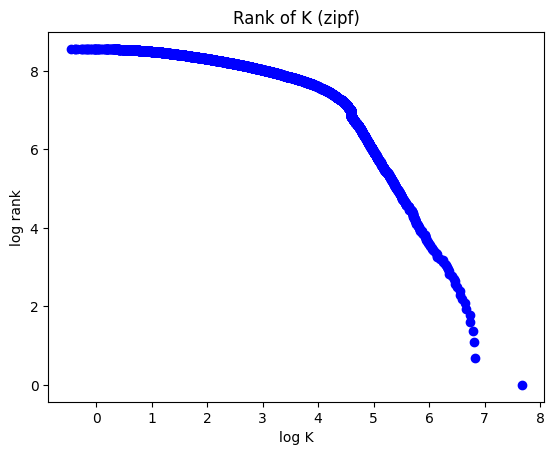

In [6]:
graph_zipf_rank(True)

<Figure size 640x480 with 0 Axes>

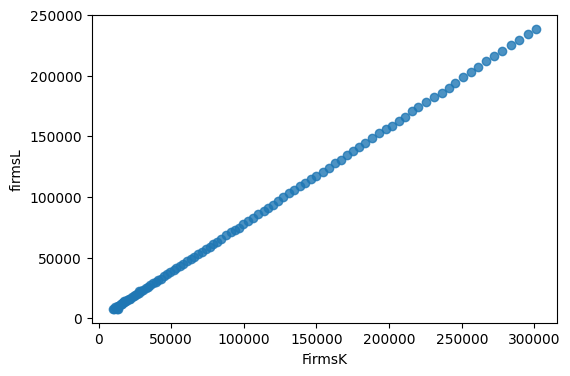

In [7]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=Statistics.firmsK, y=Statistics.firmsL, alpha= 0.8)
ax.set_xlabel('FirmsK')
ax.set_ylabel('firmsL');

<Figure size 640x480 with 0 Axes>

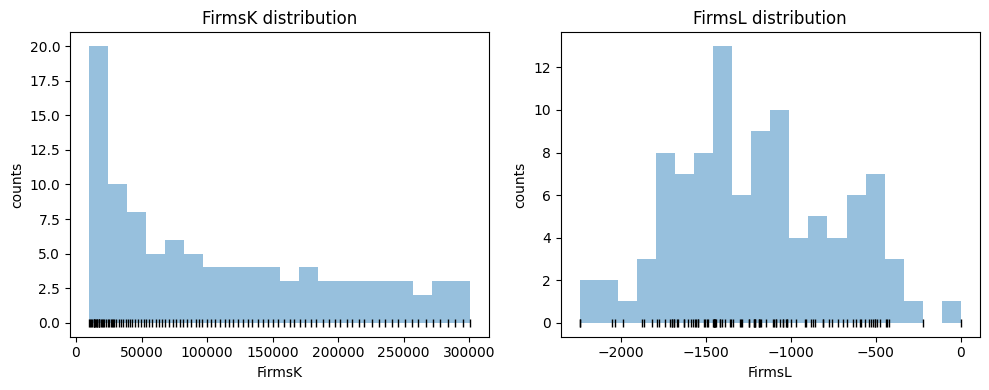

In [8]:
import statsmodels.api as sm
plt.clf()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(x=Statistics.firmsK, bins=20, color="#3182bd", alpha=0.5)
axs[0].plot(Statistics.firmsK, np.full_like(Statistics.firmsK, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('FirmsK distribution')
axs[0].set_xlabel('FirmsK')
axs[0].set_ylabel('counts')

axs[1].hist(x=Statistics.firmsπ, bins=20, color="#3182bd", alpha=0.5)
axs[1].plot(Statistics.firmsπ, np.full_like(Statistics.firmsπ, -0.01), '|k', markeredgewidth=1)
axs[1].set_title('FirmsL distribution')
axs[1].set_xlabel('FirmsL')
axs[1].set_ylabel('counts')


plt.tight_layout();

<Figure size 640x480 with 0 Axes>

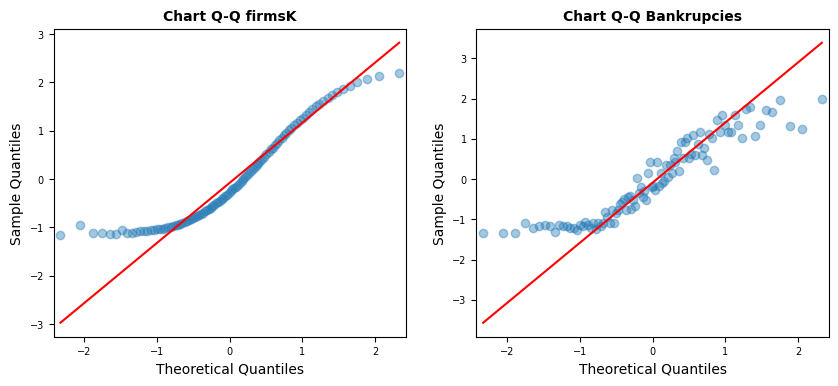

In [9]:
plt.clf()
import pandas as pd
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sm.qqplot(
    pd.DataFrame( Statistics.firmsK, columns=['K']),
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = axs[0]
)
axs[0].set_title('Chart Q-Q firmsK', fontsize = 10, fontweight = "bold")
axs[0].tick_params(labelsize = 7)

sm.qqplot(
    pd.DataFrame( Statistics.bankrupcy, columns=['Bankrupcies']),
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = axs[1]
)
axs[1].set_title('Chart Q-Q Bankrupcies', fontsize = 10, fontweight = "bold")
axs[1].tick_params(labelsize = 7)

Variable height: ShapiroResult(statistic=0.9336466193199158, pvalue=8.063588757067919e-05)


<Figure size 640x480 with 0 Axes>

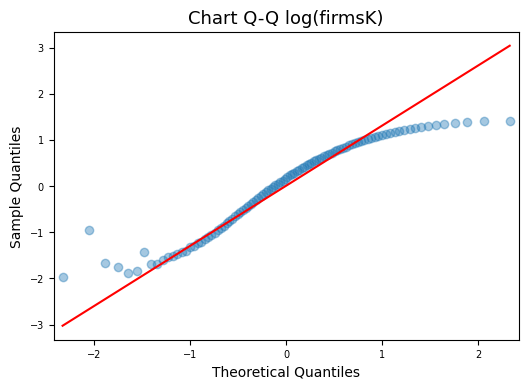

In [10]:
from scipy import stats
plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

sm.qqplot(
    np.log(pd.DataFrame( Statistics.firmsK, columns=['K'])),
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Chart Q-Q log(firmsK)', fontsize = 13)
ax.tick_params(labelsize = 7)


shapiro_test = stats.shapiro(np.log(pd.DataFrame( Statistics.firmsK, columns=['K'])))
print(f"Variable height: {shapiro_test}")

In [11]:
correlation = pd.DataFrame( zip(Statistics.firmsK,Statistics.firmsL), columns=['K','L'])
print('Coef Pearson:\n',correlation.corr(method='pearson'))
print('\nCoef Spearman:\n',correlation.corr(method='spearman'))
print('\nCoef Kendall:\n',correlation.corr(method='kendall'))


Coef Pearson:
           K         L
K  1.000000  0.999971
L  0.999971  1.000000

Coef Spearman:
           K         L
K  1.000000  0.999748
L  0.999748  1.000000

Coef Kendall:
          K        L
K  1.00000  0.99596
L  0.99596  1.00000


In [12]:
random.random()

0.4950092228648326